# Time Domain


## Definitions


### Energy

The energy of a signal, $E$, is its ability to do work. It is typically expressed in `Joules`. It can be helpful to think of this quantity as the 'area under the curve' of that signal in the time domain.

The energy of a **continuous** complex signal can be described as follows:

\begin{equation}
     E = \int_{-\infty}^{\infty} |f(t)|^{2}dt
\end{equation}

Where $f(t)$ is the instantaneous amplitude at time $t$.

As this is a continuous signal, there are infinite possible values for time and amplitude. This means that the energy of a continuous signal, such as the sine wave shown above, or any continuous tone for that matter, *must* be infinite.

The energy of a **discrete** complex signal beginning at time $T_0$ and ending at time $T_1$ can be described as follows:

\begin{equation}
     E = \int_{T_0}^{T_1} |f(t)|^{2}dt
\end{equation}

The integral above must be discretized to solve computationally (i.e., in MATLAB). It is common to approximate that integral as follows:

\begin{equation}
     E = \sum_{T_0}^{T_1} |f(t)|^{2}*dt
\end{equation}

This can be calculated in MATLAB as follows:

``` Octave
E = sum(Y.^2)*dt; 
```

### Power

Power is the energy of a signal per unit time. It's typically expressed in `Joules/second` or `Watts`. It is expressed as:

\begin{equation}
     P = \lim_{t\to\infty} \frac{1}{T} \int_{-T}^{T} |f(t)|^{2}dt
\end{equation}

This should look familiar to the equation for energy, but divided by a time unit. It may seem bizarre, but the above equation suggests that even though the energy of a continuous signal is infinite, the power must be finite. This is because there is a constant ratio between the energy and timestep, regardless of the energy level or size of the timestep used.

Power can be discritized and calculated in matlab as follows:

``` Octave
P = E / n*dt;
```

### Root Mean Square (RMS) pressure

It's often desirable to estimate the average signal strength. Because these periodic signals have both positive and negative amplitudes, the simple 'mean' of the signal is misleading and should not be used. The root mean square, or RMS, method can be a reasonable alternative. It accounts for positive and negative values by first squaring the signal, then averaging, and then taking square root of the result as follows:

\begin{equation}
     P_{rms} = \sqrt{\frac{1}{T} \int_{-T}^{T} |f(t)|^{2}dt}
\end{equation}

This can be easily applied to our power measurements like this:

``` Octave
RMS = sqrt(P);
```

### Zero to peak pressure

Perhaps the simplest measure of signal strength is zero to peak pressure. As the name suggests, this is simply the distance from zero to the maximum pressure magnitude (can be positive or negative. It can be expressed as follows:

\begin{equation}
     P_{0p} = max(|f(t)|)
\end{equation}

Let's estimate these levels for our input signals:

``` Octave
P0 = max(abs(Y));
```

### Peak to peak pressure

This is simply the difference between the minimum and maximum pressure of the signal.

\begin{equation}
     P_{pp} = max(f(t))-min(f(t))
\end{equation}

In MATLAB you can use:
``` Octave
pp = max(y)-min(y)
```

## Examples

The following section is dedicated to using MATLAB to develop an intuition for 1) how to calculate these metrics, and 2) how they are effected by changes in signal duration, frequency, amplitude among signal types.

### Common parameters

In [1]:
a = [1 2];      % signal amplitudes
f = [10 15];    % signal frequencies
d = [2 3];      % signal durations
D = 4;          % total duration
Fs = 1e3;       % sampling frequency

### Define plotting function

The following function will make it convenient for us to loop through all combinations of parameterizations, construct a given signal, calculate the metrics, and plot the output.

In [2]:
%%file plot_time_metrics.m
function plot_time_metrics(signal_type,a,f,d,Fs,D)
%% plot_time_metrics(signal_type,a,f,d,Fs,D)

dt = 1/Fs;      % sampling interval
N = Fs*D;       % length of total (samples)
T = 0:dt:D-dt;  % timesteps of total

cnt=1;
for(ii = 1:length(a))
    a_i = a(ii); % amplitude
    for(jj = 1:length(f))
        f_i = f(jj); % frequency
        for(kk = 1:length(d))
            d_i = d(kk); % duration
            
            % length of signal (samples)
            n = Fs*d_i;     
            
            % start of signal (samples)
            s0 = N/2-n/2;   
            
            % timesteps of signal
            t = 0:dt:d_i-dt;
            
            % create pad
            pad = zeros(1,s0);
            
            % create signal
            switch lower(signal_type)                
                case 'noise'
                    y = a_i/2*randn(1,n);
                    f_i = NaN; % frequency doesn't apply here
                case 'sine'
                    y = a_i*sin(2*pi*f_i*t);
                case 'pulse'
                    y = a_i*gauspuls(t,f_i,0.5,-30);
                case 'pulsetrain'                    
                    
                    % create single pulse
                    y_pulse = a_i*gauspuls(t,f_i,0.5,-30);
                    
                    % number of pulses
                    npls = 3;

                    % crop single pulse
                    pls = y_pulse(1:floor(n/npls));

                    % repeat single pulse
                    pls = repmat(pls,1,npls);

                    % combine in zero-padded array
                    y = zeros(1,n);
                    y(1:length(pls)) = pls;
                
                case 'chirp'
                    y = chirp(t,0,d_i,f_i,'linear', -90);
            end

            % pad signal
            Y = [pad y pad];
            
            % calculate energy
            E = sum(Y.^2)*dt;
            
            % calculate power
            P = E / n*dt;
            
            % calculate RMS
            RMS = sqrt(P);
            
            % calculate zero to peak
            P0 = max(abs(Y));
            
            % calculate peak to peak
            PP = max(Y)-min(Y);            
            
            % plot
            subplot(length(a)*length(f)*length(d)/2,2,cnt)
            plot(T, Y)
            ylim([-max(a) max(a)]*2)
            title({sprintf('Amplitude: %1d  Duration: %1d  Frequency: %1d', a_i, d_i, f_i),...
                sprintf('Energy: %2f  Power: %2f', E, P),...
                sprintf('RMS: %2f, P0: %2f, PP: %2f', RMS, P0, PP)})      
            
            % update counter
            cnt=cnt+1;
        end
    end
end

set(gcf, 'PaperPosition', [0 0 20 24]); % increase figure size

return

Created file '/Users/hansenjohnson/Projects/intro-acoustics/docs/plot_time_metrics.m'.


### White noise

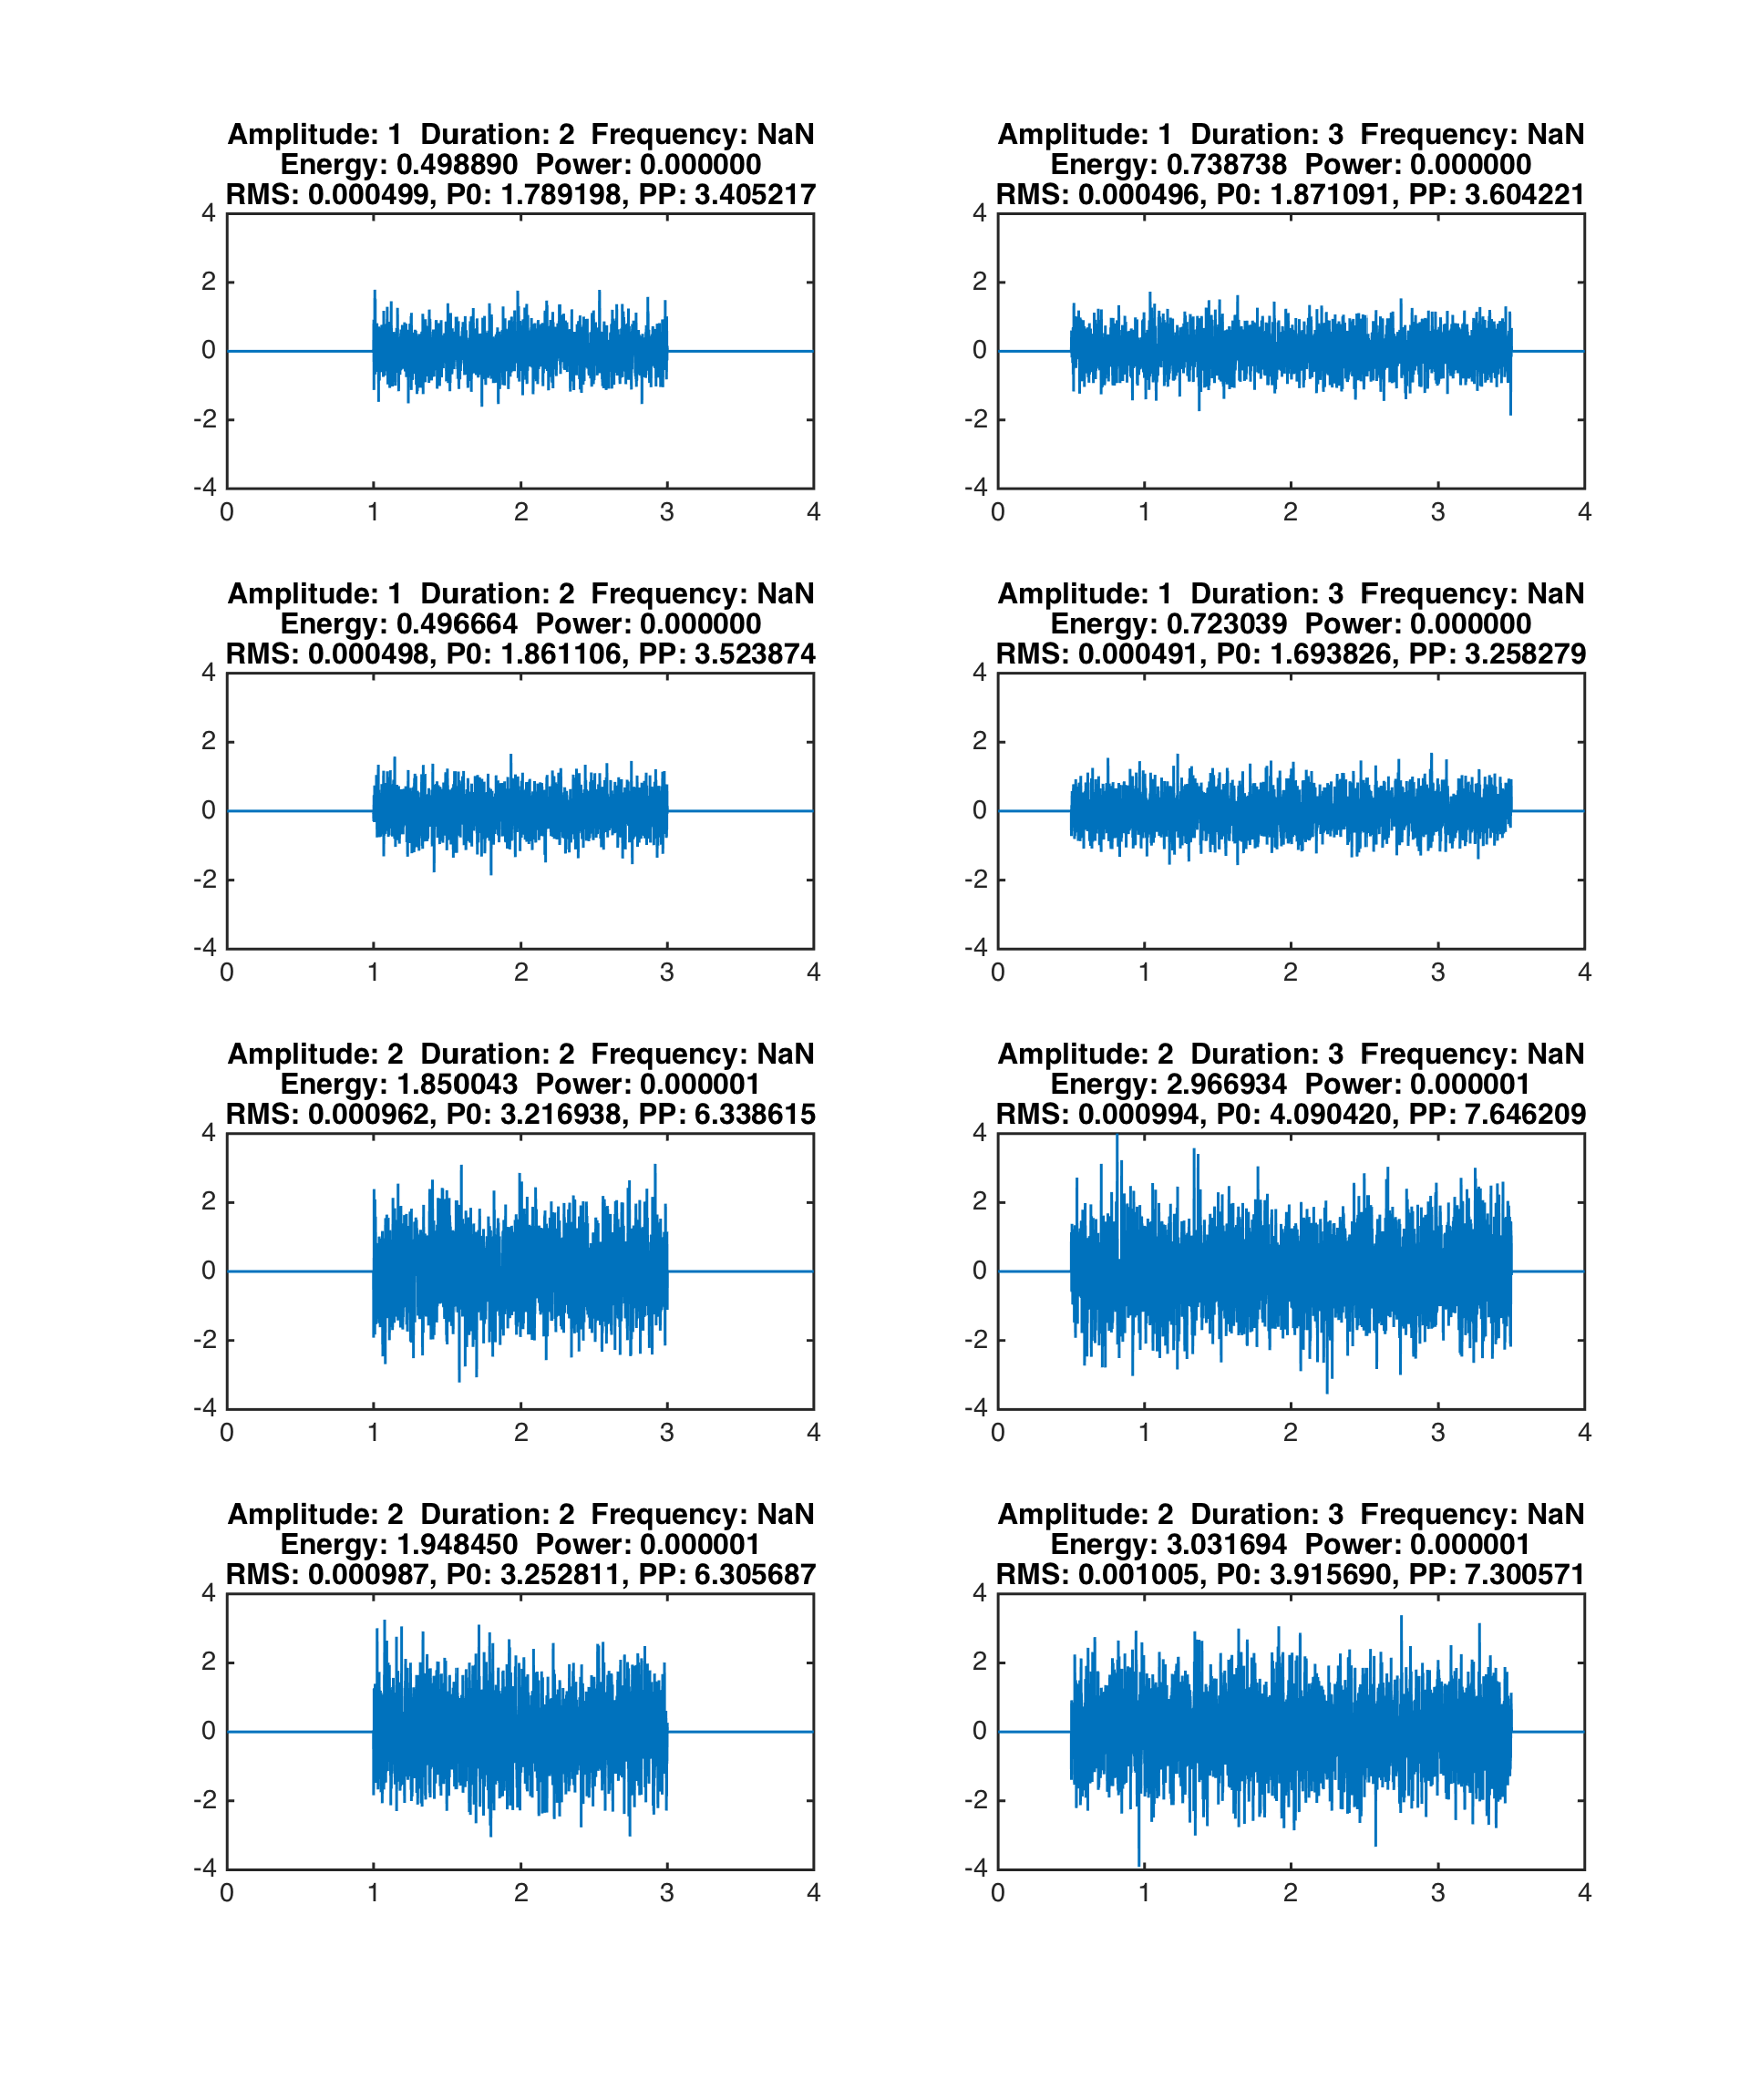

In [3]:
plot_time_metrics('noise',a,f,d,Fs,D);

### Sine wave

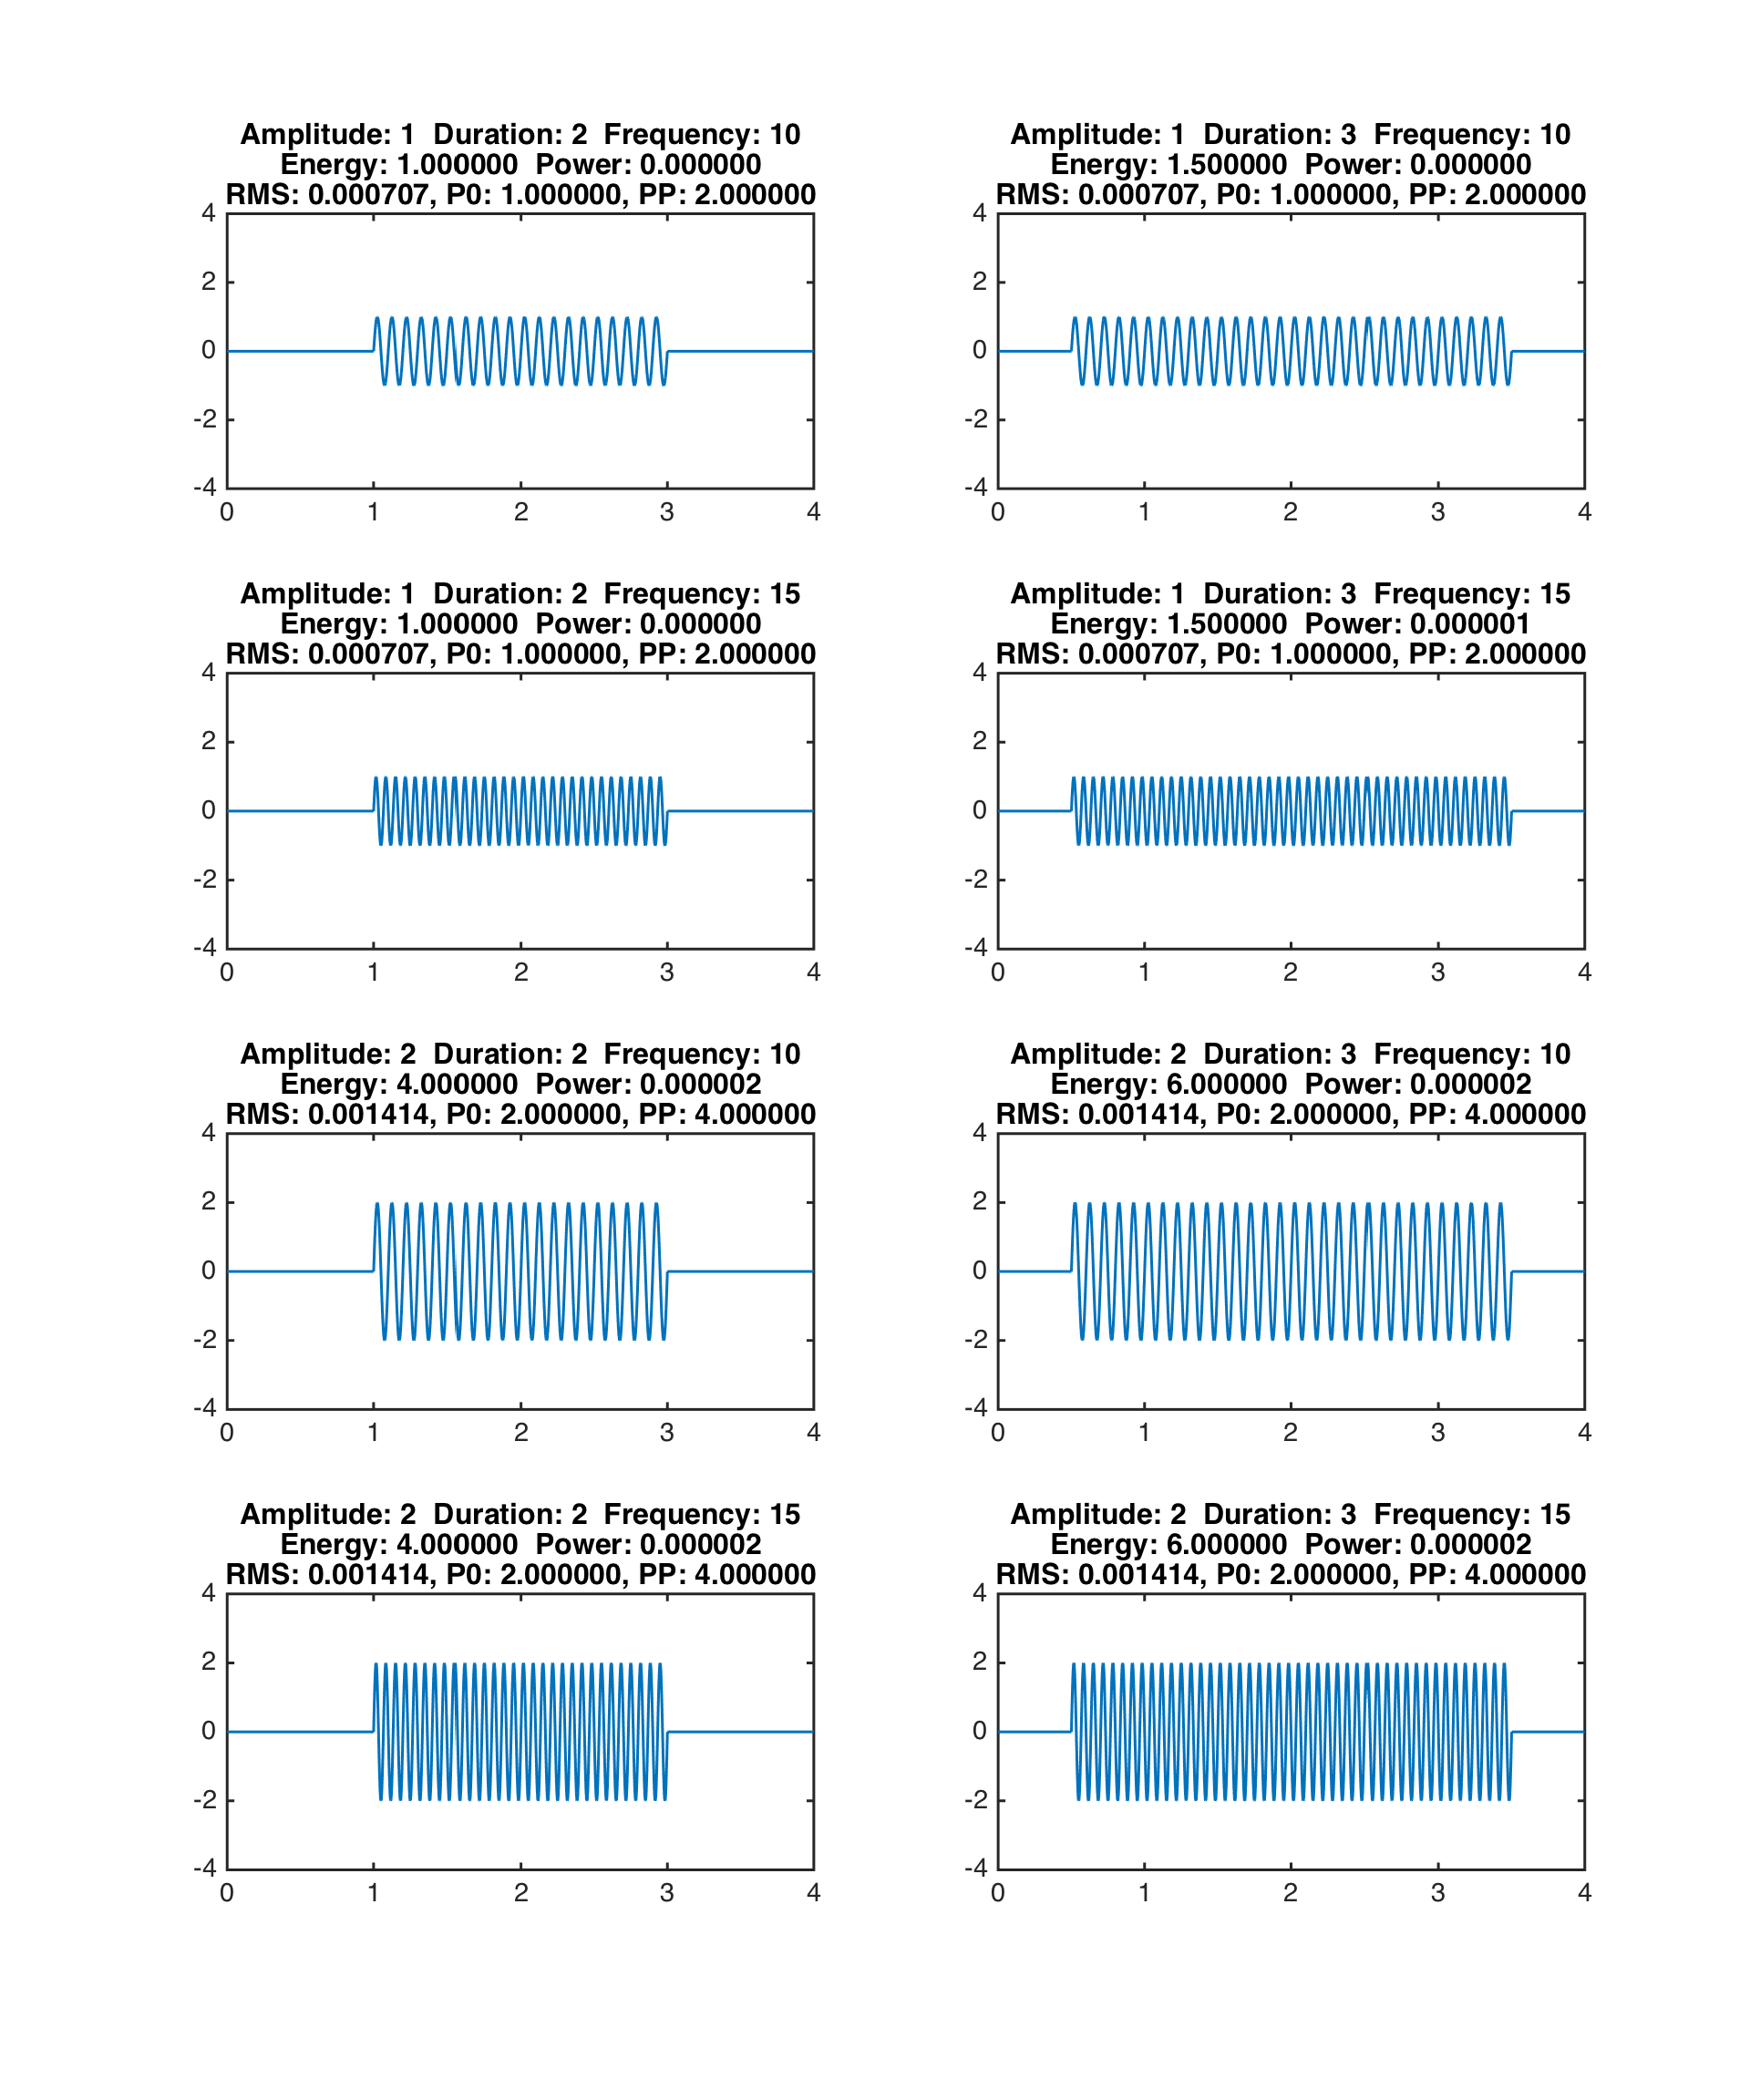

In [4]:
plot_time_metrics('sine',a,f,d,Fs,D);

### Pulse

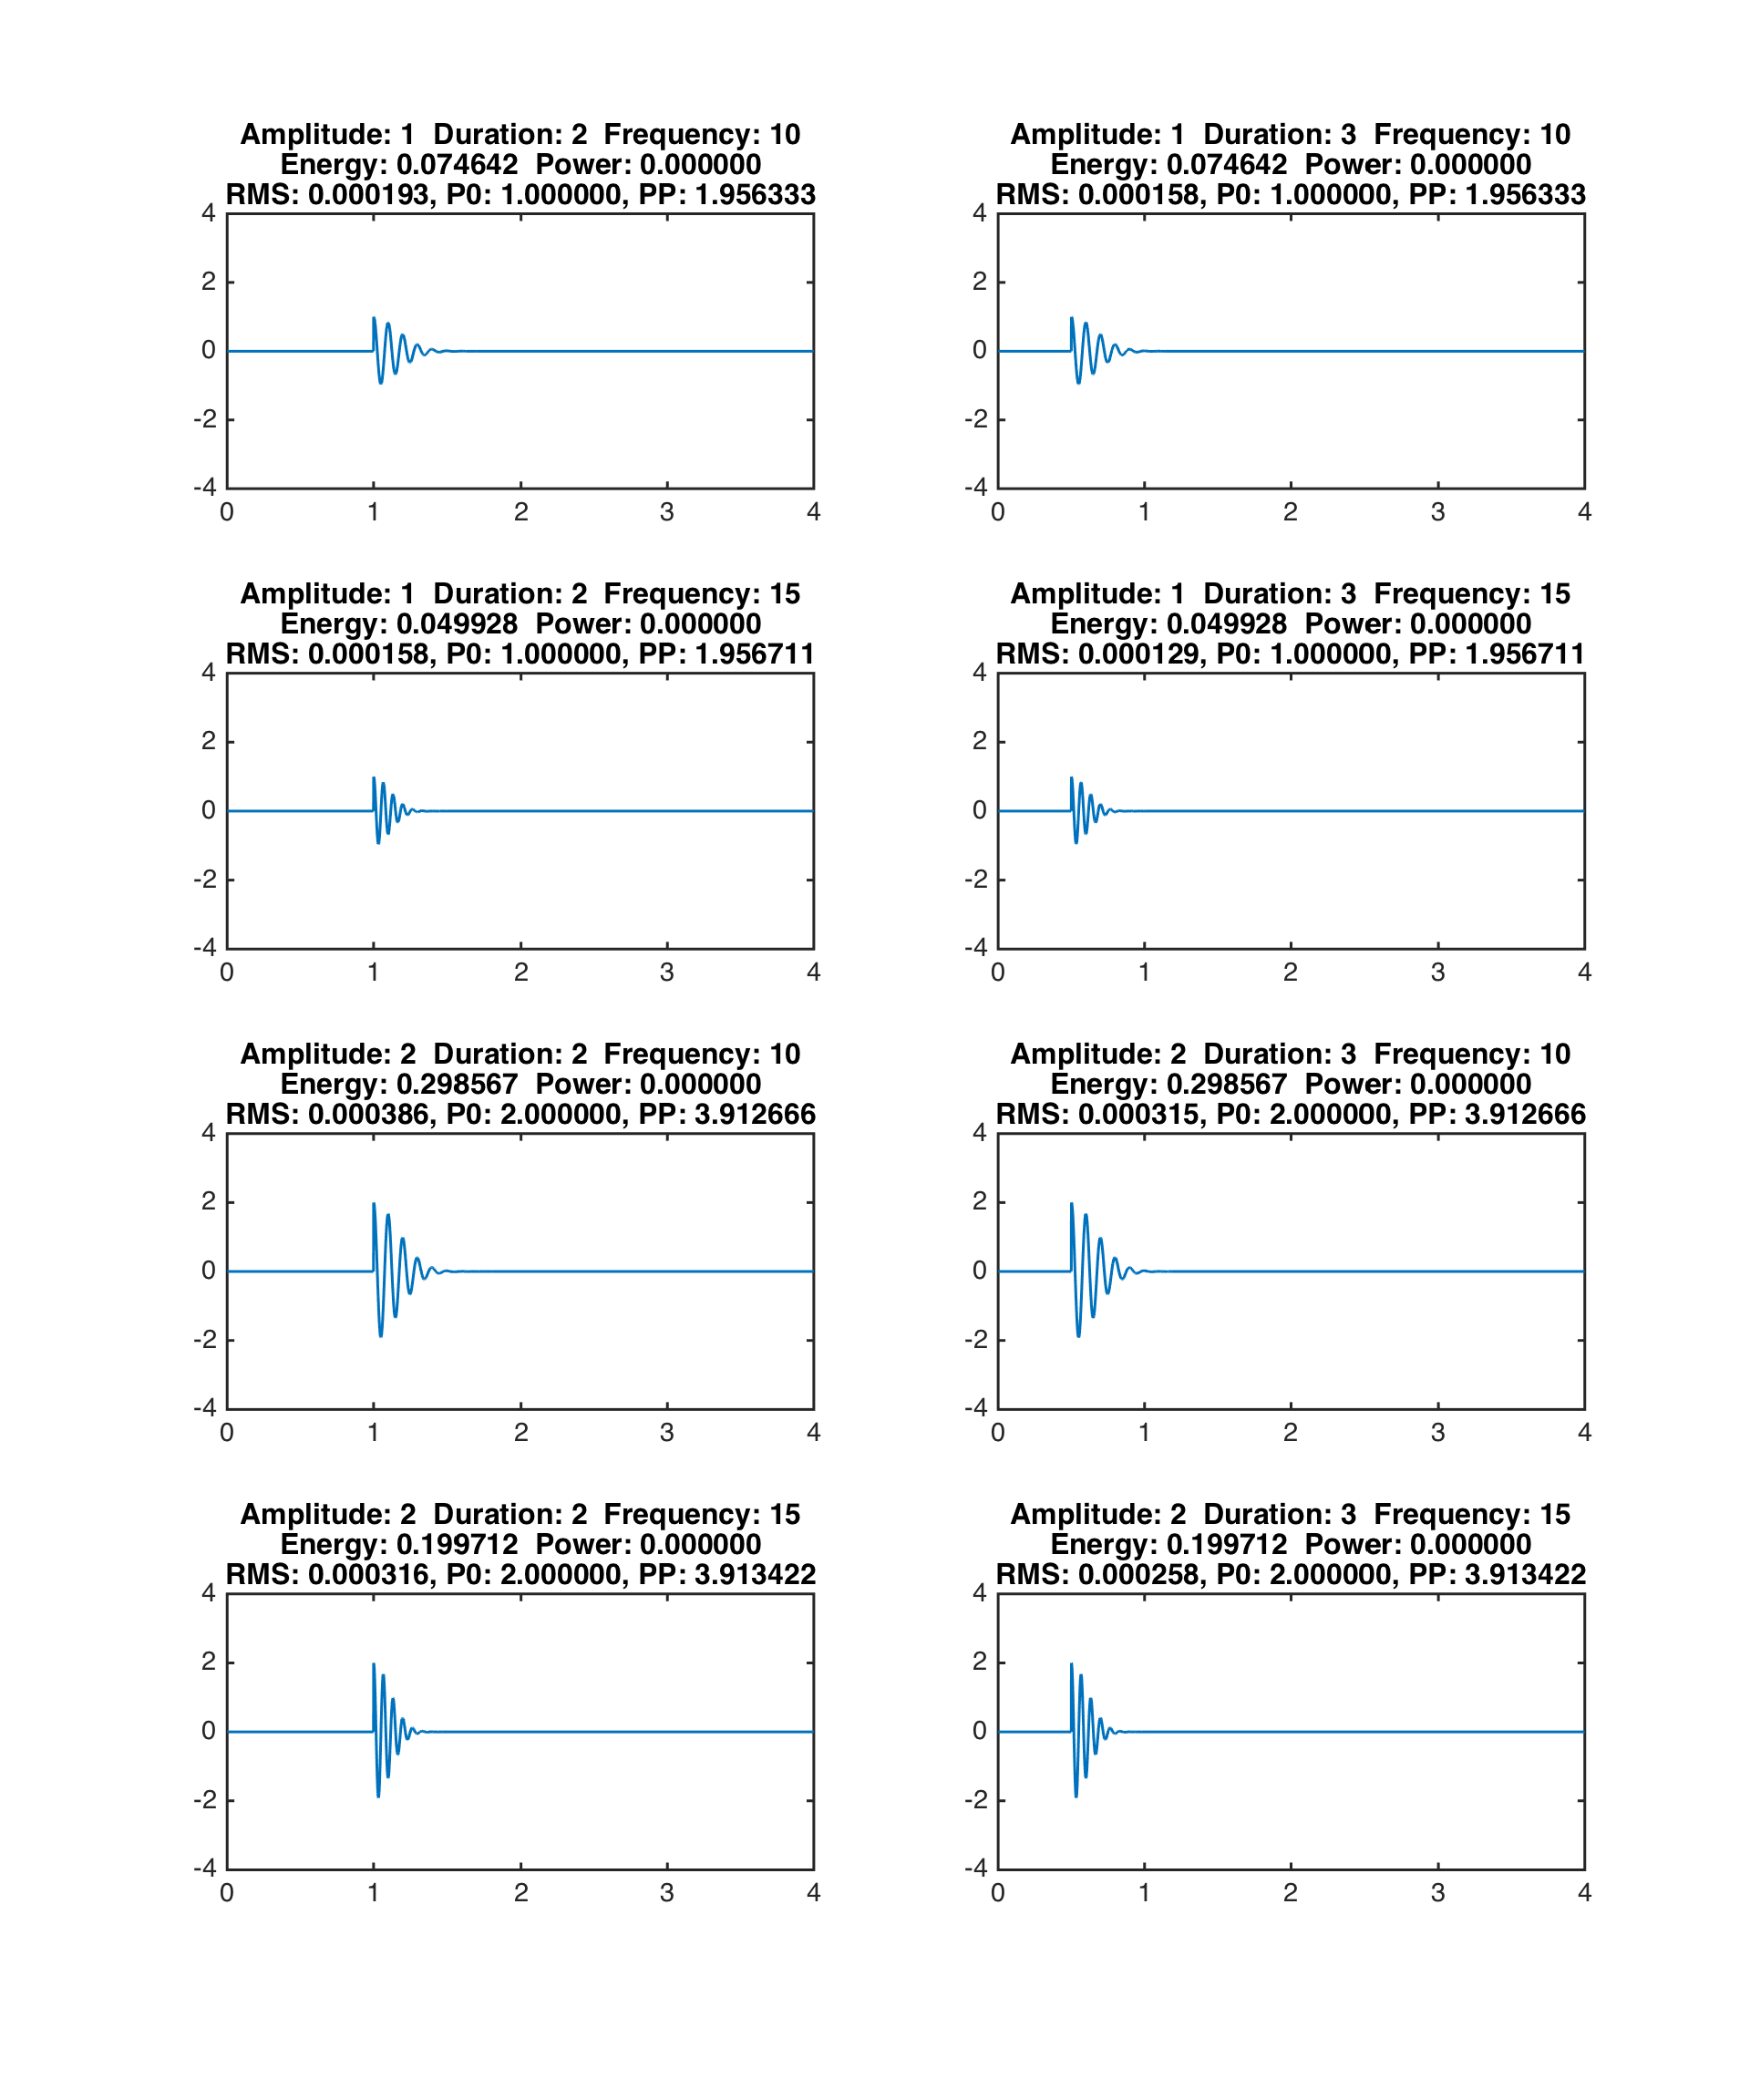

In [5]:
plot_time_metrics('pulse',a,f,d,Fs,D);

### Pulse train

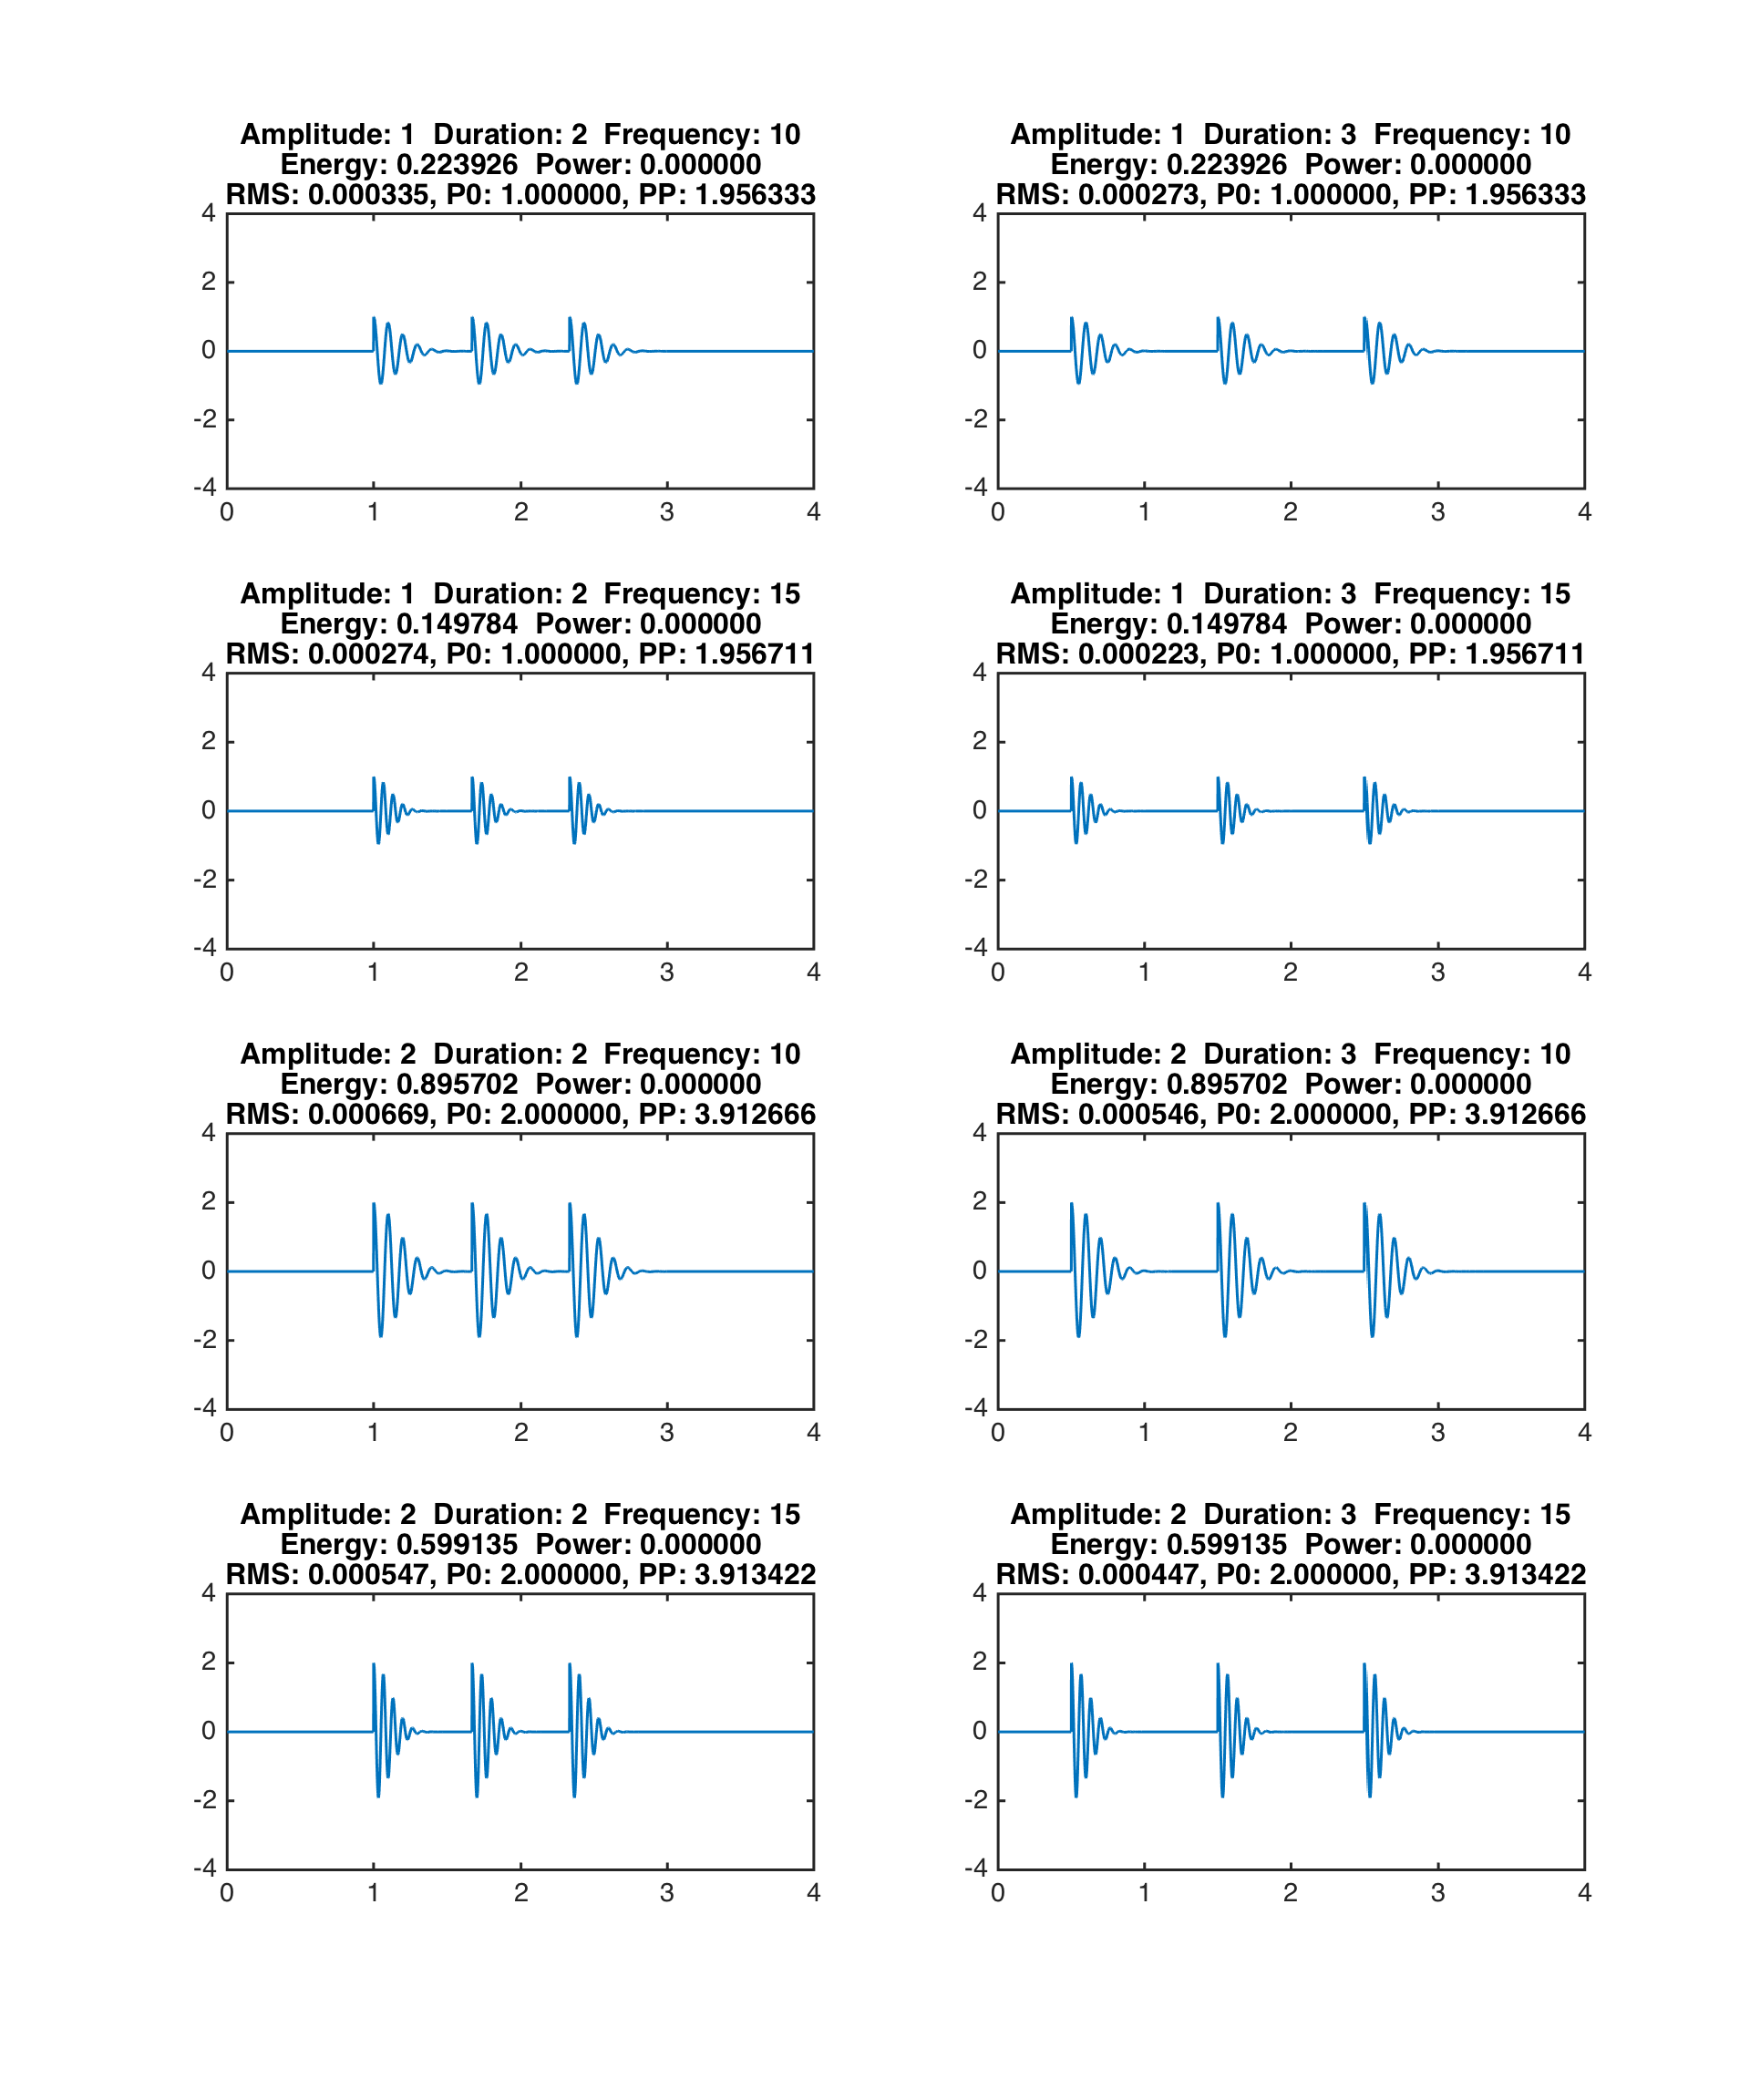

In [6]:
plot_time_metrics('pulsetrain',a,f,d,Fs,D);

### Chirp

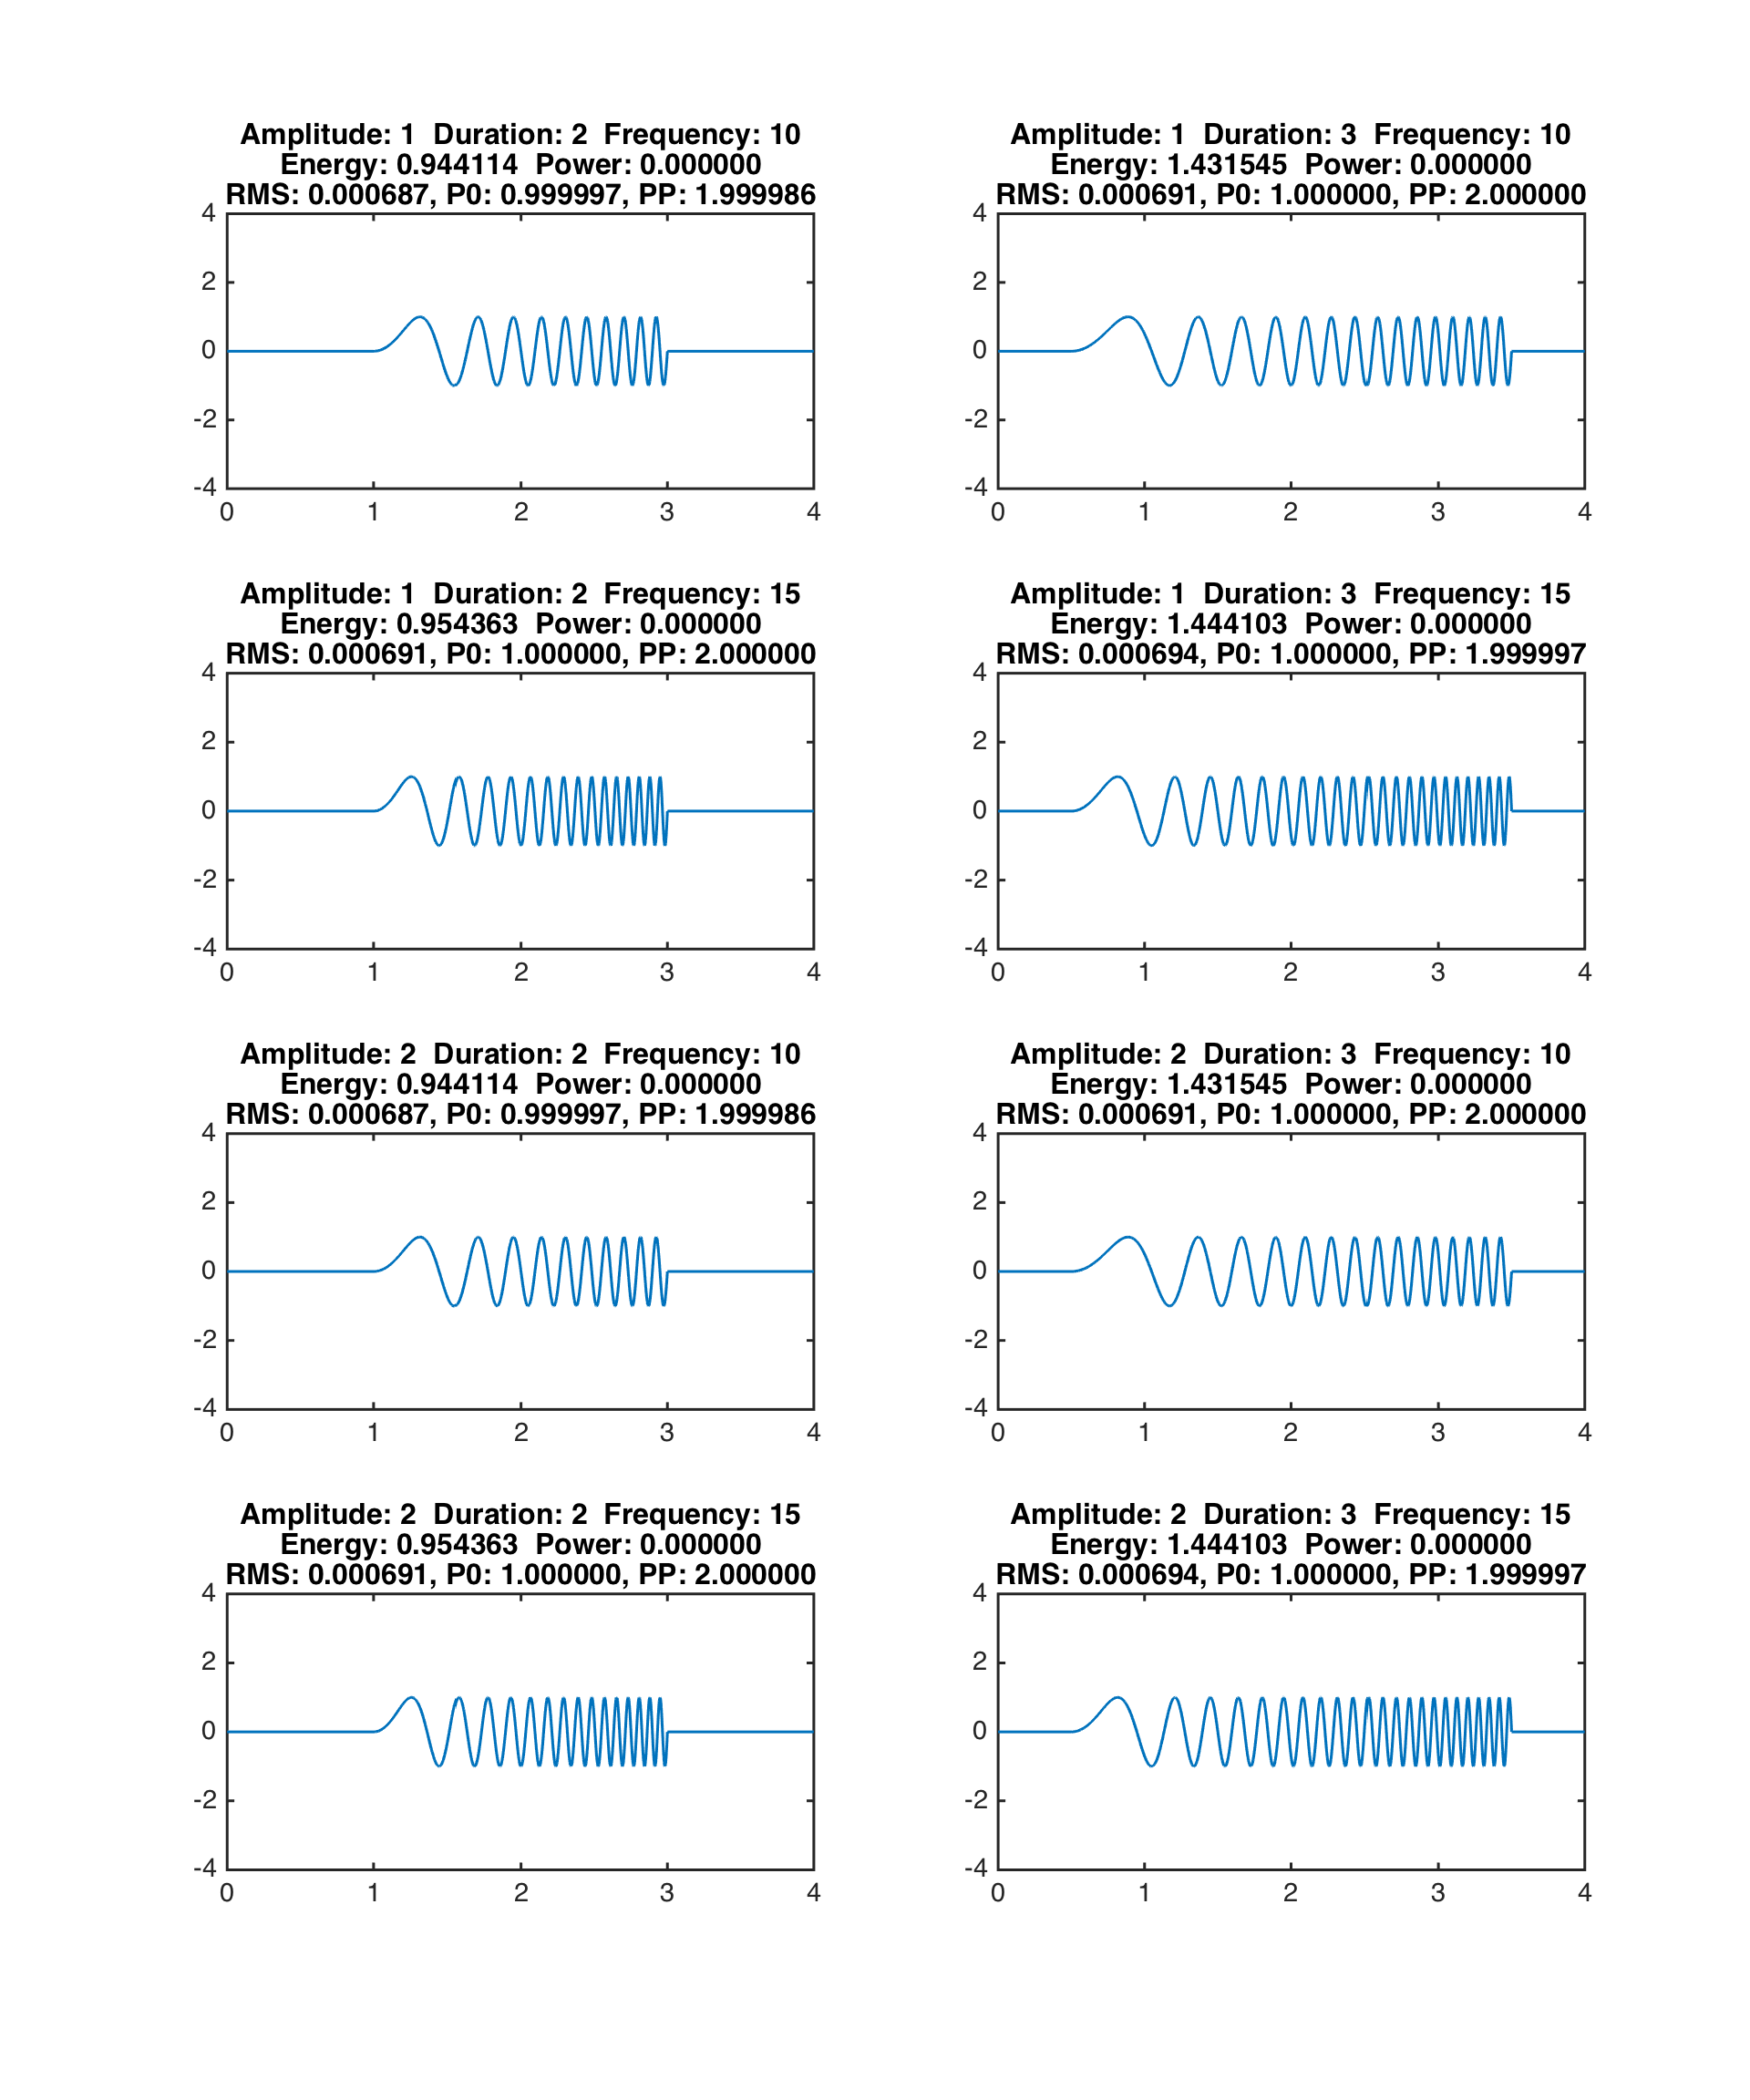

In [7]:
plot_time_metrics('chirp',a,f,d,Fs,D);